# 1. Blob Detection using Laplacian of Gaussian (LOG)

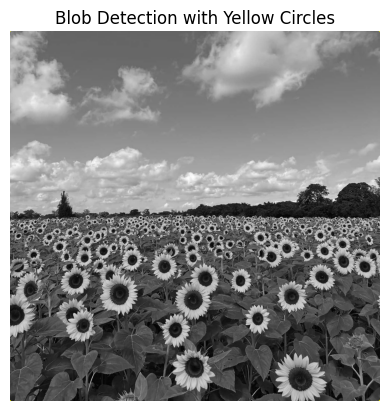

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower image in grayscale
img = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded correctly
if img is None:
    print("Error: Could not load the image. Please check the file path.")
    exit()

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Apply Laplacian of Gaussian (LoG) for edge detection
log = cv2.Laplacian(blurred, cv2.CV_64F)

# Normalize LoG values for better thresholding
log = cv2.normalize(log, None, 0, 255, cv2.NORM_MINMAX)

# Threshold to detect blobs (edges)
_, thresholded = cv2.threshold(np.uint8(log), 30, 255, cv2.THRESH_BINARY)

# Find contours (potential blobs)
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert grayscale image to BGR for drawing colored circles
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Iterate over the contours and draw yellow circles
for cnt in contours:
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    if radius > 5:  # Only draw circles for larger blobs
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(output, center, radius, (0, 255, 255), 2)  # Yellow circle

# Save the output image with yellow circles
cv2.imwrite('yellow_circled_blobs.jpg', output)

# Display the result using Matplotlib
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Blob Detection with Yellow Circles")
plt.axis('off')  # Hide axes for cleaner display
plt.show()


# 2. RANSAC for Line and Circle Fitting

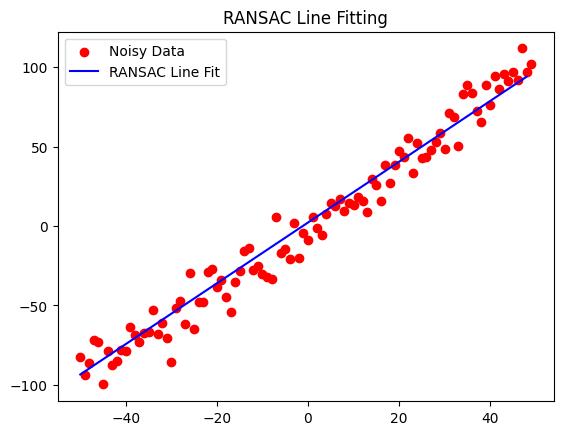

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

# Generate noisy data points along a line
np.random.seed(0)
X = np.arange(-50, 50, 1).reshape(-1, 1)
y = 2 * X.squeeze() + np.random.normal(0, 10, X.shape[0])

# Fit line using RANSAC
ransac = RANSACRegressor()
ransac.fit(X, y)

# Get line parameters
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = ransac.predict(line_X)

# Plot the data and the fitted line
plt.scatter(X, y, label='Noisy Data', color='red')
plt.plot(line_X, line_y, label='RANSAC Line Fit', color='blue')
plt.legend()
plt.title('RANSAC Line Fitting')
plt.show()


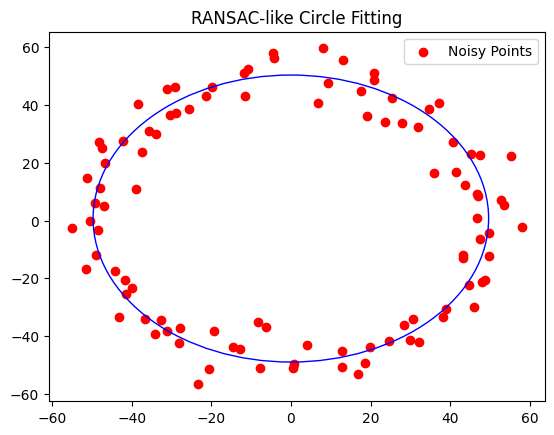

In [12]:
from scipy.optimize import least_squares

# Generate noisy data for a circle
np.random.seed(1)
theta = np.linspace(0, 2 * np.pi, 100)
x = 50 * np.cos(theta) + np.random.normal(0, 5, theta.shape)
y = 50 * np.sin(theta) + np.random.normal(0, 5, theta.shape)

def residuals(params, x, y):
    xc, yc, r = params
    return np.sqrt((x - xc) ** 2 + (y - yc) ** 2) - r

# Initial guess for circle parameters (center and radius)
x0 = np.array([0, 0, 50])
res = least_squares(residuals, x0, args=(x, y))

# Extract estimated parameters
xc, yc, r = res.x

# Plot the circle
fig, ax = plt.subplots()
ax.scatter(x, y, label='Noisy Points', color='red')
circle = plt.Circle((xc, yc), r, color='blue', fill=False)
ax.add_artist(circle)
plt.title('RANSAC-like Circle Fitting')
plt.legend()
plt.show()


# 3. Image Homography and Warping

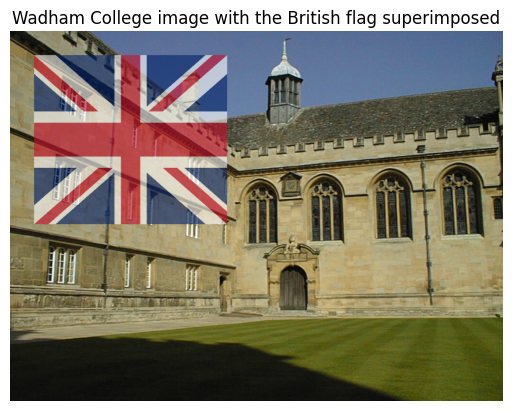

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the flag and building images
flag = cv2.imread('flag.png')
building = cv2.imread('005.jpg')

# Define four points on the flag and corresponding points on the building
pts_src = np.array([[0, 0], [flag.shape[1] - 1, 0], 
                    [flag.shape[1] - 1, flag.shape[0] - 1], 
                    [0, flag.shape[0] - 1]], dtype=float)

pts_dst = np.array([[50, 50], [450, 50], [450, 400], [50, 400]], dtype=float)

# Compute the homography matrix
H, _ = cv2.findHomography(pts_src, pts_dst)

# Warp the flag image onto the building's dimensions
warped_flag = cv2.warpPerspective(flag, H, (building.shape[1], building.shape[0]))

# Create a mask for the warped flag (single channel)
mask = np.zeros((building.shape[0], building.shape[1]), dtype=np.uint8)
cv2.fillConvexPoly(mask, pts_dst.astype(int), 255)

# Convert the mask to 3 channels to match the images' shape
mask_3d = cv2.merge([mask, mask, mask])

# Blend the flag with the building using alpha blending
alpha = 0.6  # Adjust transparency (0 = only building, 1 = only flag)
warped_flag_blended = cv2.addWeighted(warped_flag, alpha, building, 1 - alpha, 0)

# Use the mask to overlay the blended flag only on the intended area
final_result = np.where(mask_3d == 255, warped_flag_blended, building)

# Display the result using Matplotlib
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.title('Wadham College image with the British flag superimposed')
plt.axis('off')  # Hide axes for a cleaner display
plt.show()


# 4. Image Stitching using SIFT and RANSAC

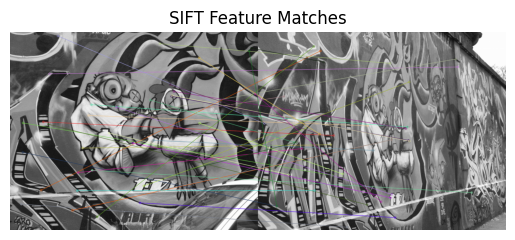

Computed Homography Matrix:
 [[-1.26369739e+00 -2.67552562e-01  1.87640592e+02]
 [-2.14423826e+00 -4.96429764e-01  3.38885096e+02]
 [-6.44996432e-03 -1.42355193e-03  1.00000000e+00]]


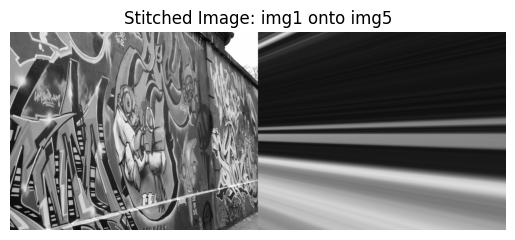

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

# Part (a): Compute and match SIFT features between img1.ppm and img5.ppm

# Load the two images to be stitched
img1 = cv2.imread('graf/img1.ppm', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('graf/img5.ppm', cv2.IMREAD_GRAYSCALE)

# Check if the images are loaded correctly
if img1 is None or img5 is None:
    print("Error: One or both images not found or failed to load.")
    sys.exit(1)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)

# Match descriptors using FLANN-based matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des5, k=2)

# Filter good matches using the ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Visualize the matches
match_img = cv2.drawMatches(img1, kp1, img5, kp5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(match_img)
plt.title('SIFT Feature Matches')
plt.axis('off')
plt.show()

# Part (b): Compute the homography using RANSAC
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Use RANSAC to compute the homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print("Computed Homography Matrix:\n", H)

# (Optional) Compare with provided homography matrix from dataset
# Assuming dataset_homography contains the reference matrix:
# dataset_homography = np.loadtxt('graf/homography.txt')  # Example
# print("Provided Homography Matrix:\n", dataset_homography)

# Part (c): Stitch img1.ppm onto img5.ppm using the computed homography
# Warp img1 to align with img5 using the computed homography
result = cv2.warpPerspective(img1, H, (img1.shape[1] + img5.shape[1], img1.shape[0]))
result[0:img5.shape[0], 0:img5.shape[1]] = img5

# Display the final stitched image
plt.imshow(result, cmap='gray')
plt.title('Stitched Image: img1 onto img5')
plt.axis('off')
plt.show()
